In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as trans
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np
import PIL

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from models import fixed_networks as fnet
from utils import gan_utils as gutils
from utils import style_utils as sutils

if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

# load pretrained loss network, only need feature parts
loss_net = torchvision.models.squeezenet1_1(pretrained=True).features
loss_net.type(dtype)
for param in loss_net.parameters():
    param.requires_grad = False

# load pretrained generators
G_C = fnet.lsv_Gen_BN_R()
G_C.load_state_dict(torch.load('./savemodels/pretrained_gan_112/G_epoch_24.pkl'))
G_C.type(dtype)
G_C.eval()

G_S = fnet.lsv_Gen_BN_R()
G_S.type(dtype)

print("Generator's state_dict:")
for param_tensor in G_C.state_dict():
    print(param_tensor, "\t", G_C.state_dict()[param_tensor].size())

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


Generator's state_dict:
0.weight 	 torch.Size([12544, 1024])
0.bias 	 torch.Size([12544])
1.weight 	 torch.Size([12544])
1.bias 	 torch.Size([12544])
1.running_mean 	 torch.Size([12544])
1.running_var 	 torch.Size([12544])
4.weight 	 torch.Size([256, 256, 3, 3])
4.bias 	 torch.Size([256])
5.weight 	 torch.Size([256])
5.bias 	 torch.Size([256])
5.running_mean 	 torch.Size([256])
5.running_var 	 torch.Size([256])
7.weight 	 torch.Size([256, 256, 3, 3])
7.bias 	 torch.Size([256])
8.weight 	 torch.Size([256])
8.bias 	 torch.Size([256])
8.running_mean 	 torch.Size([256])
8.running_var 	 torch.Size([256])
10.weight 	 torch.Size([256, 256, 3, 3])
10.bias 	 torch.Size([256])
11.weight 	 torch.Size([256])
11.bias 	 torch.Size([256])
11.running_mean 	 torch.Size([256])
11.running_var 	 torch.Size([256])
13.weight 	 torch.Size([256, 256, 3, 3])
13.bias 	 torch.Size([256])
14.weight 	 torch.Size([256])
14.bias 	 torch.Size([256])
14.running_mean 	 torch.Size([256])
14.running_var 	 torch.Size([256

In [2]:
def show_images(content_images, style_images):
    sqrtn = int(np.ceil(np.sqrt(content_images.shape[0])))
    
    fig = plt.figure(figsize=(2*sqrtn, sqrtn))
    
    gs = gridspec.GridSpec(1, 2)
    gs.update(wspace=0.1, hspace=0.05)
    
    inner = gridspec.GridSpecFromSubplotSpec(sqrtn, sqrtn, subplot_spec=gs[0], wspace=0.05, hspace=0.05)

    for i, img in enumerate(content_images):
        ax = plt.subplot(inner[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.transpose(1, 2, 0))
    
    inner = gridspec.GridSpecFromSubplotSpec(sqrtn, sqrtn, subplot_spec=gs[1], wspace=0.05, hspace=0.05)

    for i, img in enumerate(style_images):
        ax = plt.subplot(inner[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.transpose(1, 2, 0))
    return

In [3]:
def train_style(g_c, g_s, batchsize, noize_dim, style_target, style_size, loss_net, 
                style_layers, style_weights, content_layer, content_weight, tv_weight,
                num_iter=51, show_every=50):
    
    # load style target
    style_img = sutils.style_target_preprocess(PIL.Image.open(style_target), size=style_size)
    style_img = style_img.type(dtype)
    style_feats = sutils.extract_features(style_img, loss_net)
    style_grams = []
    for idx in style_layers:
        style_grams.append(sutils.gram_matrix(style_feats[idx].clone()))

    # Set up optimization hyperparameters
    initial_lr = 1e-4
    
    g_s_params = []
    for param in g_s.parameters():
        if param.requires_grad == True:
            g_s_params.append(param)

    optimizer = torch.optim.Adam(g_s_params, lr=initial_lr) # hyperparameters TBD
    
    for t in range(num_iter):
        optimizer.zero_grad()

        # sample latent variable
        z = gutils.input_noise_uniform(batchsize, noize_dim).type(dtype)

        fake_contents = g_c(z).detach()
        fake_images = g_s(z)
        if t % show_every == 0:
            simgs_numpy = gutils.deprocess_img(fake_images.clone().cpu().detach().numpy())
        fake_images_pro = sutils.fake_image_preprocess(fake_images)

        content_target = sutils.extract_features(fake_contents, loss_net)
        content_target = content_target[content_layer].clone()
        fake_feats = sutils.extract_features(fake_images, loss_net)
        
        # Compute loss
        c_loss = sutils.content_loss(content_weight, fake_feats[content_layer], content_target)
        s_loss = sutils.style_loss(fake_feats, style_layers, style_grams, style_weights)
        t_loss = sutils.tv_loss(fake_images, tv_weight)
        loss = c_loss + s_loss + t_loss
        
        loss.backward()        
        optimizer.step()

        if t % show_every == 0:
            print('Iter '+str(t)+':')
            cimgs_numpy = gutils.deprocess_img(fake_contents.cpu().numpy())
            show_images(cimgs_numpy[0:64], simgs_numpy[0:64])
            plt.show()
            
    return

Iter 0:


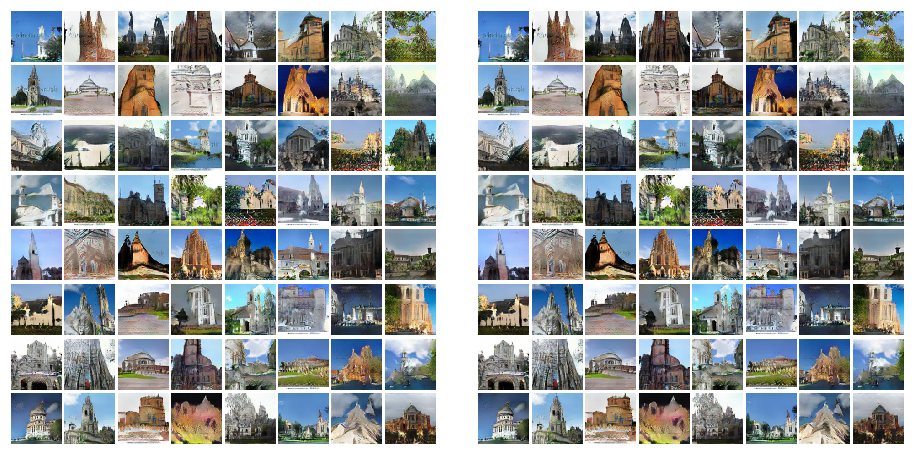

Iter 10:


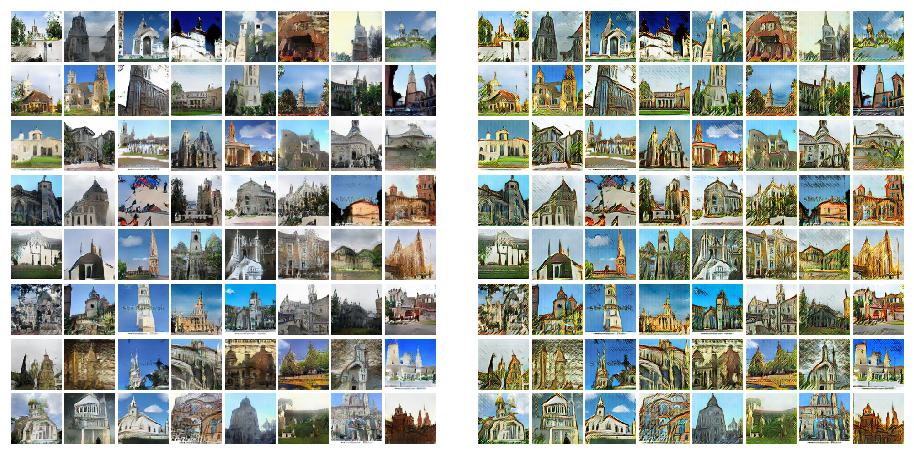

Iter 20:


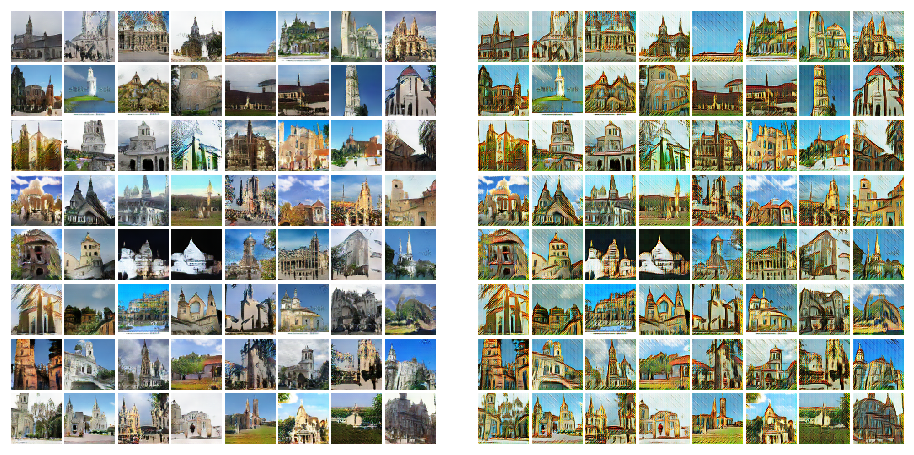

Iter 30:


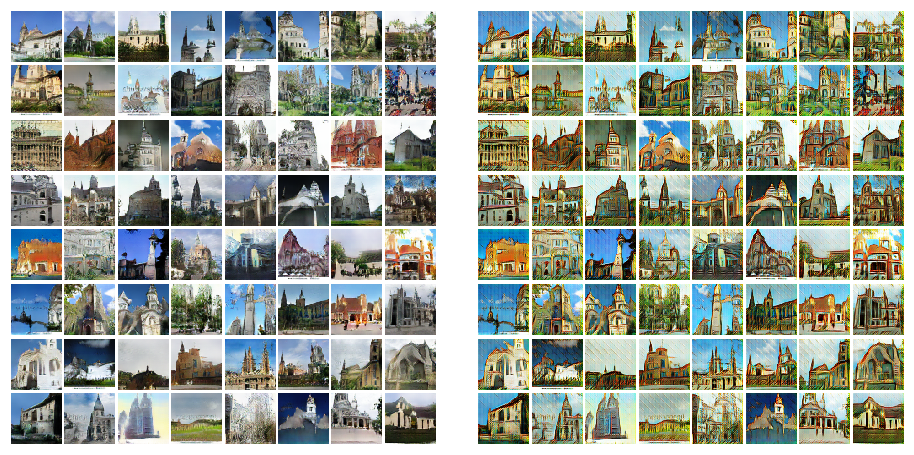

Iter 40:


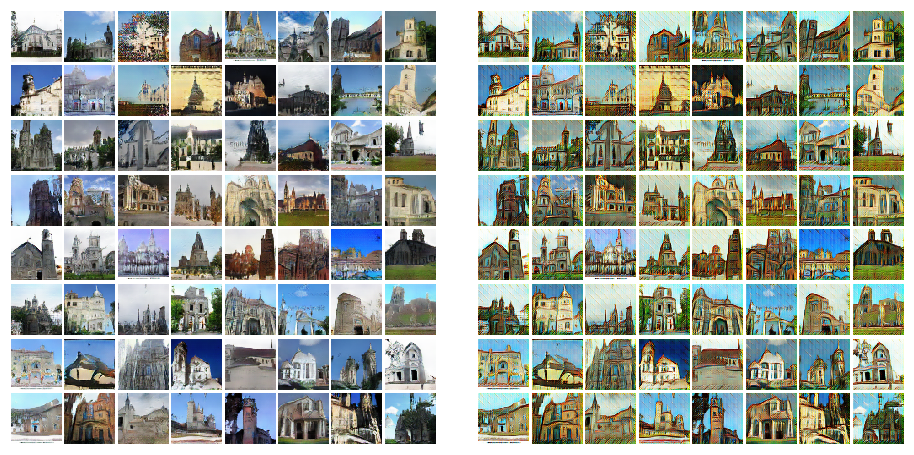

Iter 50:


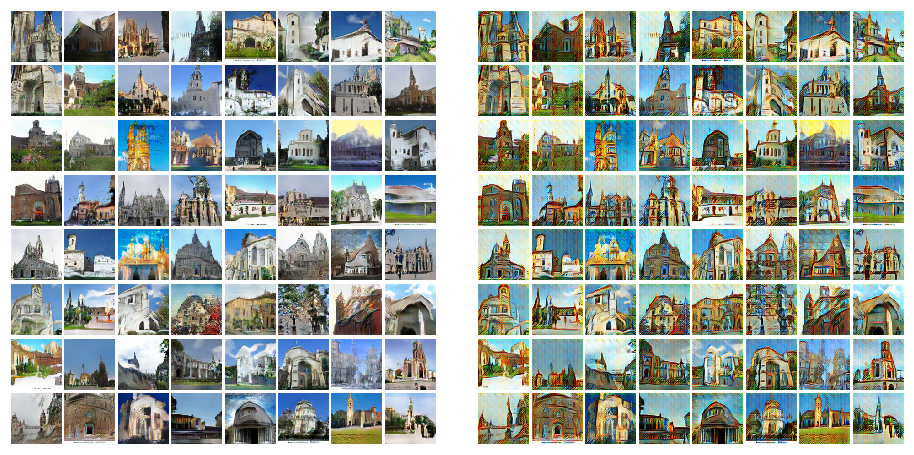

In [4]:
G_S.load_state_dict(torch.load('./savemodels/pretrained_gan_112/G_epoch_24.pkl'))
for i, param in enumerate(G_S.parameters()):
    if i > -1:
        param.requires_grad = True
    else:
        param.requires_grad = False

train_style(G_C, G_S, 128, 1024, './styles/muse.jpg', 112, loss_net, 
            [1, 4, 6, 7], [24, 400, 3, 0.25], 3, 3.5e-1, 2e-2, num_iter=51, show_every=10)